In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm

print(torch.__version__)

1.8.0.dev20201128


Use some data

In [29]:
import pickle
for dataset in [#'biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0].astype(int)
    print(dataset)
    print("\tdata shape:", X.shape)
    print(f"\trange of X values: {X.min()} -- {X.max()}")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
            a=pickle.load(f)
    X=a[0]
    X=X.astype(int)

    print("data shape:", X.shape)
    print(f"range of X values: {X.min()} -- {X.max()}")
    print(f"setting d={X.max()+1}")
    d = X.max()+1
    return X, d

flare
	data shape: (1065, 13)
	range of X values: 0 -- 7
lymphography
	data shape: (148, 19)
	range of X values: 0 -- 7
spect
	data shape: (187, 23)
	range of X values: 0 -- 1
tumor
	data shape: (339, 17)
	range of X values: 0 -- 3
votes
	data shape: (435, 17)
	range of X values: 0 -- 2


In [30]:
X,d = load_dataset('flare')

data shape: (1065, 13)
range of X values: 0 -- 7
setting d=8


In [31]:
D = 4
mps       = PosMPS(X, d, D, homogeneous=False)
mps_hom   = PosMPS(X, d, D, homogeneous=True)

rBorn     = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 

cBorn     = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)

rBorn_s   = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 

cBorn_s   = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)

models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)
for model in (*models, *models_hom):
    print(model.core.shape, "model type:", model.name)
    for p in model.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")

torch.Size([13, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous
torch.Size([13, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous
torch.Size([13, 8, 4, 4]) model type: Born (torch.float32), Non-homogeneous + log_stability
torch.Size([13, 8, 4, 4]) model type: Born (torch.complex64), Non-homogeneous + log_stability
torch.Size([13, 8, 4, 4]) model type: Positive MPS, Non-homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous
torch.Size([8, 4, 4]) model type: Born (torch.float32), Homogeneous + log_stability
torch.Size([8, 4, 4]) model type: Born (torch.complex64), Homogeneous + log_stability
torch.Size([8, 4, 4]) model type: Positive MPS, Homogeneous


In [32]:
import matplotlib.pyplot as plt
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.SGD(self.parameters(), **optim_kwargs)
    loss_values = [] # to plot
    print('/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯\n')
    print(f"Training {self.name}.")
    av_batch_loss_running = -1000
    for epoch in tqdm(range(max_epochs), leave=True):
#         print("epoch", epoch)
        batch_loss = []
        for batch_idx, batch in enumerate(trainloader):
#             print(list(self.parameters()))
            for p in self.parameters():
                if torch.isnan(p).any():
                    print("Model weights contain a NaN value!")
                    if plot:
                        plt.plot(loss_values)
                        plt.show()
                    return loss_values
            self.zero_grad()
            neglogprob = 0
            for i,x in enumerate(batch):
                out = self(x)
    #             print(i, out)
                neglogprob -= out
    #             print("out",out)
            loss = neglogprob / len(batch)
    #         print("core befor\n",self.core[0][0])
    #         if batch_idx>0:
    #             print("\tgrad:",self.core.grad[0,0])
            loss.backward()
    #         print("backward.")
#             print("\tgrad:",self.core.grad[0,0])
            optimizer.step()
    #         print("optimize\n",self.core[0][0])
    #         print("\tgrad:",self.core.grad[0,0])
            with torch.no_grad():
                batch_loss.append(loss.item())
#                 n=5
#                 if batch_idx % n == 0: # print every nth batch loss
#                     print("\tbatch", batch_idx, "size", len(batch), "loss", loss.item())
        av_batch_loss = torch.Tensor(batch_loss).mean().item()
#         print(f"ep{epoch} av_batch_loss\t {av_batch_loss}")
        loss_values.append(av_batch_loss)
        if abs(av_batch_loss_running - av_batch_loss) < .0001:
            print("Early stopping")
            break
        av_batch_loss_running = av_batch_loss
    print("loss_values", loss_values)
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('\_____Finished_training_____\n')
    return loss_values

# train(rBorn, X, batchsize=30, max_epochs = 10, lr=0.1)

In [ ]:
model_loss_values={}
for model in models_hom:
    loss_values = train(model, X, batchsize=30, plot=False, max_epochs = 60, lr=0.05)
    plt.plot(loss_values, label=model.name)
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

/¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

Training Born (torch.float32), Homogeneous.


In [ ]:
model_loss_values={}
for model in models:
    loss_values = train(model, X, batchsize=30, plot=False, max_epochs = 60, lr=0.05)
    plt.plot(loss_values, label=model.name)
    model_loss_values["model.name"]=loss_values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [57]:
# testing complex functions
real = torch.tensor([[1, 2],[2, 1]], dtype=torch.float32)
imag = torch.tensor([[3, 4],[1, 2]], dtype=torch.float32)
z = torch.complex(real, imag)
# z = torch.randn(2,2, dtype=torch.cfloat)
z.requires_grad=True
b = (2.7j*z + 3.4*z + 18)
L = torch.einsum('ij,ji,ij,ji->',b,b,b,b).abs()
L.backward()

print("z:\n",z,'\n', sep='')
print("loss grad_fn:\n", L.grad_fn,'\n', sep='')
print("z.grad:\n", z.grad,'\n', sep='')

def infnorm(tensor):
#     return torch.max(torch.sum(abs(tensor), dim=-1))
    print(tensor.abs().max())
    return torch.linalg.norm(tensor, ord=float('inf')).real

norm = infnorm
print(norm(z.grad))
print(norm(z.grad[0]))

z:
tensor([[1.+3.j, 2.+4.j],
        [2.+1.j, 1.+2.j]], requires_grad=True)

loss grad_fn:

z.grad:
tensor([[103476.6328-38667.7930j, 224180.9375+59425.4219j],
        [219980.8125-67495.4922j, 105286.0781+37877.9062j]])

tensor(231923.4219)
tensor(342388.8438)
tensor(231923.4219)
tensor(231923.4219)


In [20]:
print(matnorm(z))
print(torch.max(torch.sum(abs(z), dim=1)))

tensor(7.6344+0.j, grad_fn=<CopyBackwards>)
tensor(7.6344, grad_fn=<MaxBackward1>)


In [145]:
((D*D*d)**(-0.5)*torch.randn(d, D, D, dtype=torch.cfloat)).sum()

tensor(1.1485-0.0851j)

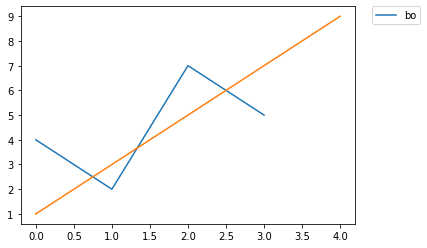

In [11]:
torch.randn(D, dtype=torch.cfloat)

tensor([-1.2039-1.3208j,  0.4049+0.5211j, -0.2646-0.9657j, -0.5759-0.1643j])

In [9]:
# nn.Parameter(torch.randn((d, D, D), dtype=torch.cfloat))